In [2]:
!pip3 install torchio
!pip3 install pytorch_lightning

In [3]:
import torch
import torchio as tio
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import multiprocessing

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.step = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(),
        )

    def forward(self, X):
        return self.step(X)

In [5]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Downsampling path
        self.layer1 = DoubleConv(1, 32)
        self.layer2 = DoubleConv(32, 64)
        self.layer3 = DoubleConv(64, 128)
        self.layer4 = DoubleConv(128, 256)
        # Upsampling path
        self.layer5 = DoubleConv(256 + 128, 128)
        self.layer6 = DoubleConv(128 + 64, 64)
        self.layer7 = DoubleConv(64 + 32, 32)
        self.layer8 = nn.Conv3d(32, 3, 1)
        self.maxpool = nn.MaxPool3d(2)

    def forward(self, x):
        # Downsample
        x1 = self.layer1(x)
        x1m = self.maxpool(x1)
        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)
        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)
        x4 = self.layer4(x3m)
        # Upsample
        x5 = nn.Upsample(scale_factor=2, mode="trilinear", align_corners=True)(x4)
        x5 = torch.cat([x5, x3], dim=1)
        x5 = self.layer5(x5)
        x6 = nn.Upsample(scale_factor=2, mode="trilinear", align_corners=True)(x5)
        x6 = torch.cat([x6, x2], dim=1)
        x6 = self.layer6(x6)
        x7 = nn.Upsample(scale_factor=2, mode="trilinear", align_corners=True)(x6)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.layer7(x7)
        # Final output
        ret = self.layer8(x7)
        return ret

In [6]:
class Segmenter(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = UNet()
        self.loss_fn = nn.CrossEntropyLoss()
        self.loss_history = {'train': [], 'val': []}
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        img = batch['CT'][tio.DATA].float()
        mask = batch['Label'][tio.DATA][:, 0].long()
        pred = self(img)
        loss = self.loss_fn(pred, mask)
        self.log("Train Loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        img = batch['CT'][tio.DATA].float()
        mask = batch['Label'][tio.DATA][:, 0].long()
        pred = self(img)
        loss = self.loss_fn(pred, mask)
        self.log("Val Loss", loss)
        return loss

    def configure_optimizers(self):  # ADD THIS METHOD
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [7]:
def change_img_to_label_path(path):
    return Path(str(path).replace("imagesTr", "labelsTr"))

In [8]:
def main():
    # Load dataset
    path = Path("/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/imagesTr")
    subjects_paths = list(path.glob("liver_*"))
    subjects = []

    for subject_path in subjects_paths:
        label_path = change_img_to_label_path(subject_path)
        subject = tio.Subject(
            CT=tio.ScalarImage(subject_path),
            Label=tio.LabelMap(label_path)
        )
        subjects.append(subject)

    # Split dataset
    train_size = int(0.8 * len(subjects))
    train_subjects = subjects[:train_size]
    val_subjects = subjects[train_size:]

    # Define preprocessing transforms
    preprocessing = tio.Compose([
        tio.CropOrPad((256, 256, 200)),
        tio.RescaleIntensity((-1, 1)),
    ])

    # Define augmentation transforms
    augmentation = tio.Compose([
        tio.RandomAffine(scales=(0.9, 1.1), degrees=10),
        tio.RandomGamma(p=0.5),
        tio.RandomNoise(p=0.5),
    ])

    # Create datasets with transforms
    train_transform = tio.Compose([preprocessing, augmentation])
    val_transform = preprocessing

    train_dataset = tio.SubjectsDataset(train_subjects, transform=train_transform)
    val_dataset = tio.SubjectsDataset(val_subjects, transform=val_transform)

    # Define patch-based sampling parameters
    patch_size = 96
    samples_per_volume = 10
    batch_size = 2

    # Create samplers for patch-based training
    train_sampler = tio.data.UniformSampler(patch_size)
    validation_sampler = tio.data.UniformSampler(patch_size)

    # Create patch-based datasets
    patches_training_set = tio.Queue(
        subjects_dataset=train_dataset,
        max_length=300,
        samples_per_volume=samples_per_volume,
        sampler=train_sampler,
        num_workers=4,
        shuffle_subjects=True,
        shuffle_patches=True,
    )

    patches_validation_set = tio.Queue(
        subjects_dataset=val_dataset,
        max_length=300,
        samples_per_volume=samples_per_volume,
        sampler=validation_sampler,
        num_workers=4,
        shuffle_subjects=False,
        shuffle_patches=False,
    )

    # Create data loaders
    train_loader = tio.SubjectsLoader(
        patches_training_set,
        batch_size=batch_size,
        num_workers=0,  # Queue handles multiprocessing internally
    )

    val_loader = tio.SubjectsLoader(
        patches_validation_set,
        batch_size=batch_size,
        num_workers=0,  # Queue handles multiprocessing internally
    )

    # Initialize model and trainer
    model = Segmenter()

    checkpoint_callback = ModelCheckpoint(
        monitor="Val Loss",
        dirpath="checkpoints",
        filename="best_model-{epoch:02d}-{Val Loss:.2f}",
        save_top_k=1,
        mode="min",
    )

    trainer = pl.Trainer(
        max_epochs=1,
        logger=TensorBoardLogger(save_dir="logs", name="liver_segmentation"),
        callbacks=[checkpoint_callback],
        accelerator="auto",
        devices=1,
        log_every_n_steps=1,
    )

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    # Save the final model
    torch.save(model.state_dict(), "final_model.pth")
    print("Training completed. Model saved to final_model.pth")

In [10]:
if __name__ == '__main__':
    multiprocessing.freeze_support()
    main()

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training completed. Model saved to final_model.pth


<ipython-input-9-75bd7097eaea>:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load("final_model.pth"))


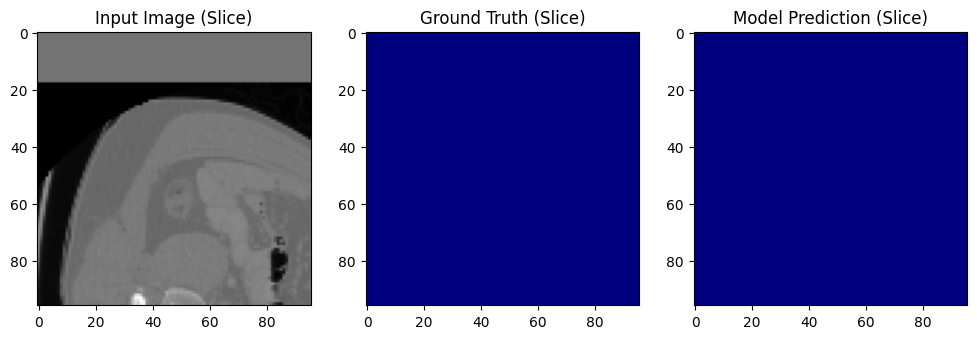

In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, val_loader):
    """Evaluate the trained model using one sample from the validation set."""
    model.eval()  # Set model to evaluation mode

    # Get one sample from the validation set
    batch = next(iter(val_loader))
    img = batch['CT'][tio.DATA].float()
    mask = batch['Label'][tio.DATA][:, 0].long()

    with torch.no_grad():
        pred = model(img).argmax(dim=1)  # Convert logits to segmentation labels

    # Convert tensors to numpy arrays
    img_np = img[0, 0].cpu().numpy()  # Shape: (96, 96, 96)
    mask_np = mask[0].cpu().numpy()  # Shape: (96, 96, 96)
    pred_np = pred[0].cpu().numpy()  # Shape: (96, 96, 96)

    # Select the middle slice along the depth axis
    mid_slice = img_np.shape[2] // 2  # Middle slice index

    img_slice = img_np[:, :, mid_slice]  # Extracting a 2D slice
    mask_slice = mask_np[:, :, mid_slice]  # Extracting a 2D slice
    pred_slice = pred_np[:, :, mid_slice]  # Extracting a 2D slice

    # Display results
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(img_slice, cmap="gray")
    ax[0].set_title("Input Image (Slice)")

    ax[1].imshow(mask_slice, cmap="jet")
    ax[1].set_title("Ground Truth (Slice)")

    ax[2].imshow(pred_slice, cmap="jet")
    ax[2].set_title("Model Prediction (Slice)")

    plt.show()

if __name__ == '__main__':
    # Load trained model for evaluation
    test_model = Segmenter()
    test_model.load_state_dict(torch.load("final_model.pth"))

    # Load dataset again (if not already available)
    path = Path("/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/imagesTr")
    subjects_paths = list(path.glob("liver_*"))
    subjects = [tio.Subject(CT=tio.ScalarImage(p), Label=tio.LabelMap(change_img_to_label_path(p))) for p in subjects_paths]

    train_size = int(0.8 * len(subjects))
    val_subjects = subjects[train_size:]

    val_transform = tio.Compose([tio.CropOrPad((256, 256, 200)), tio.RescaleIntensity((-1, 1))])
    val_dataset = tio.SubjectsDataset(val_subjects, transform=val_transform)

    validation_sampler = tio.data.UniformSampler(96)
    patches_validation_set = tio.Queue(
        subjects_dataset=val_dataset,
        max_length=300,
        samples_per_volume=10,
        sampler=validation_sampler,
        num_workers=4,
        shuffle_subjects=False,
        shuffle_patches=False,
    )

    val_loader = tio.SubjectsLoader(
        patches_validation_set,
        batch_size=1,  # Only one sample for evaluation
        num_workers=0,
    )

    # Run evaluation
    evaluate_model(test_model, val_loader)


In [10]:
!pip3 install celluloid

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from celluloid import Camera
from IPython.display import HTML

def evaluate_model(model, val_loader, sample_path, sample_path_label):
    """Evaluate the trained model using one sample from the validation set and compute Dice score."""
    model.eval()  # Set model to evaluation mode

    # Load sample data
    data = nib.load(sample_path)
    label = nib.load(sample_path_label)

    ct = data.get_fdata()  # 3D CT scan
    mask = label.get_fdata().astype(int)  # Convert mask to int for segmentation labels

    # Ensure consistent dimensions
    depth = min(ct.shape[2], mask.shape[2])  # Get the minimum depth
    ct = ct[:, :, :depth]  # Trim CT scan
    mask = mask[:, :, :depth]  # Trim mask

    # Run model prediction
    batch = next(iter(val_loader))
    img = batch['CT'][tio.DATA].float()
    mask_gt = batch['Label'][tio.DATA][:, 0].long()

    with torch.no_grad():
        pred = model(img).argmax(dim=1)  # Convert logits to segmentation labels

    pred_np = pred[0].cpu().numpy()  # Convert tensor to NumPy array
    mask_np = mask_gt[0].cpu().numpy()  # Convert ground truth to NumPy array

    # Ensure `pred_np` depth matches the actual scan depth
    pred_np = pred_np[:, :, :depth]  # Trim prediction to match CT scan depth
    mask_np = mask_np[:, :, :depth]  # Trim mask to match CT scan depth

    # ---- Dice Score Calculation ----
    # Flatten arrays
    pred_flat = pred_np.flatten()
    mask_flat = mask_np.flatten()

    # Compute True Positive (TP), False Positive (FP), False Negative (FN)
    tp = (pred_flat * mask_flat).sum()
    fp = pred_flat.sum() - tp
    fn = mask_flat.sum() - tp

    # Compute Dice Score
    dice_score = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 0

    print(f"Dice Score: {dice_score:.4f}")

if __name__ == '__main__':
    # Load trained model for evaluation
    test_model = Segmenter()
    test_model.load_state_dict(torch.load("final_model.pth"))

    # Load dataset again (if not already available)
    path = Path("/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/imagesTr")
    subjects_paths = list(path.glob("liver_*"))
    subjects = [tio.Subject(CT=tio.ScalarImage(p), Label=tio.LabelMap(change_img_to_label_path(p))) for p in subjects_paths]

    train_size = int(0.8 * len(subjects))
    val_subjects = subjects[train_size:]

    val_transform = tio.Compose([tio.CropOrPad((256, 256, 200)), tio.RescaleIntensity((-1, 1))])
    val_dataset = tio.SubjectsDataset(val_subjects, transform=val_transform)

    validation_sampler = tio.data.UniformSampler(96)
    patches_validation_set = tio.Queue(
        subjects_dataset=val_dataset,
        max_length=300,
        samples_per_volume=10,
        sampler=validation_sampler,
        num_workers=4,
        shuffle_subjects=False,
        shuffle_patches=False,
    )

    val_loader = tio.SubjectsLoader(
        patches_validation_set,
        batch_size=1,  # Only one sample for evaluation
        num_workers=0,
    )

    # Provide sample file paths
    sample_path = "/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/imagesTr/liver_1.nii"
    sample_path_label = "/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/labelsTr/liver_1.nii"

    # Run evaluation
    evaluate_model(test_model, val_loader, sample_path, sample_path_label)


<ipython-input-12-db46baeb05f4>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load("final_model.pth"))


Dice Score: 0.0000


<ipython-input-14-567ed3bb7cfd>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("final_model.pth"))
/usr/local/lib/python3.10/dist-package

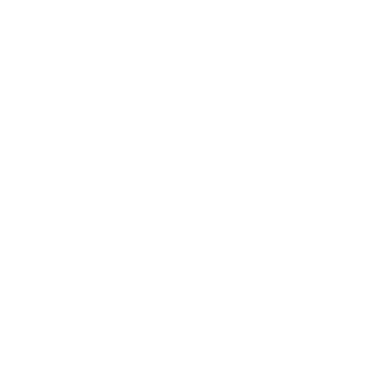

In [14]:
import torch
import torchio as tio
import matplotlib.pyplot as plt
import numpy as np
from celluloid import Camera
from IPython.display import HTML

# Load trained model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Segmenter()
model.load_state_dict(torch.load("final_model.pth"))
model = model.eval().to(device)

# Select a validation subject and extract images/masks
IDX = 4  # Change to select another validation sample
val_subject = val_dataset[IDX]
mask = val_subject["Label"]["data"]  # Ground truth mask
imgs = val_subject["CT"]["data"]  # CT scan

# Create GridSampler and GridAggregator
grid_sampler = tio.inference.GridSampler(val_subject, patch_size=96, patch_overlap=(8, 8, 8))
aggregator = tio.inference.GridAggregator(grid_sampler)

# DataLoader for batch-wise prediction
patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=4)

# Perform inference and aggregate patches
with torch.no_grad():
    for patches_batch in patch_loader:
        input_tensor = patches_batch['CT']["data"].to(device)  # Get batch of patches
        locations = patches_batch[tio.LOCATION]  # Get locations of patches
        pred = model(input_tensor)  # Compute prediction
        aggregator.add_batch(pred, locations)  # Merge patch predictions

# Extract the final full-volume prediction
output_tensor = aggregator.get_output_tensor().argmax(0)  # Convert logits to segmentation labels

# Create animation
fig = plt.figure()
camera = Camera(fig)

for i in range(0, output_tensor.shape[2], 2):  # Axial view, skipping every second slice
    plt.imshow(imgs[0, :, :, i], cmap="bone")  # Original CT scan
    mask_overlay = np.ma.masked_where(output_tensor[:, :, i] == 0, output_tensor[:, :, i])
    gt_overlay = np.ma.masked_where(mask[0, :, :, i] == 0, mask[0, :, :, i])

    plt.imshow(mask_overlay, alpha=0.5, cmap="jet")  # Overlay model prediction
    plt.imshow(gt_overlay, alpha=0.5, cmap="coolwarm")  # Overlay ground truth mask (optional)

    plt.axis("off")
    camera.snap()  # Capture the frame

# Create and display the animation
animation = camera.animate()
HTML(animation.to_html5_video())
